In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
from math import log10, sqrt
device = "mps" if torch.backends.mps.is_available() else "cpu"

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
from math import log10, sqrt
device = "mps" if torch.backends.mps.is_available() else "cpu"

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:

            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 1
        down_channels = (16, 32, 64)
        up_channels = (64, 32, 16)
        out_dim = 1
        time_emb_dim = 16

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], time_emb_dim) for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True) for i in range(len(up_channels)-1)])
        
        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)

            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("STDM Parameters:",params)

233025


In [8]:
class DQN(nn.Module):

    def __init__(self, n_actions):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding = 1)
        self.conv2 = nn.Conv2d(32, 16, 3, padding = 1)
        self.conv3 = nn.Conv2d(16, 8, 3, padding = 1)
        self.conv4 = nn.Conv2d(8, 4, 3, padding = 1)
        self.pooling = nn.MaxPool2d(3)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(36, 16)
        self.fc2 = nn.Linear(16, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        # print(x.shape)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pooling(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pooling(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pooling(x)
        # print(x.shape)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

model = DQN(8)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("DQN Parameters:",params)

DQN Parameters: 7700


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
from math import log10, sqrt
device = "mps" if torch.backends.mps.is_available() else "cpu"

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:

            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 1
        down_channels = (16, 32, 64)
        up_channels = (64, 32, 16)
        out_dim = 1
        time_emb_dim = 16

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], time_emb_dim) for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True) for i in range(len(up_channels)-1)])
        
        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)

            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
# summary(model, [(1,100, 100), (1,1)])


def get_loss(model, x, y, t):
    y_pred = model(x, t)
    return F.l1_loss(y, y_pred)     


input = np.load("input_wofire_16.npy")
output = np.load("output_wofire_16.npy")
sensor_values = np.load("sensor_values_wofire_16.npy")

input = torch.from_numpy(input)
output = torch.from_numpy(output)
sensor_values = torch.from_numpy(sensor_values)
# last column
time = sensor_values[:,-1]
input, output, time = input.type(torch.float32), output.type(torch.float32), time.type(torch.float32)


input = input.resize_(input.shape[0], 1, input.shape[1], input.shape[2])
output = output.resize_(output.shape[0], 1, output.shape[1], output.shape[2])
# time = time.resize_(time.shape[0], 1)

model = model.to(device)
input = input.to(device)
output = output.to(device)
time = time.to(device)
train_tensor = TensorDataset(input, time, output)
train_dataloader = DataLoader(train_tensor, batch_size=50)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 200

for epoch in range(epochs):
    for step, batch in enumerate(train_dataloader):
      optimizer.zero_grad()
      t = batch[1]
      loss = get_loss(model, batch[0], batch[2], t)
      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | Loss: {loss.item()} ")

torch.save(model.state_dict(), "dm_unet_10K_wofire_16")

Epoch 0 | Loss: 0.3300155699253082 
Epoch 5 | Loss: 0.21643505990505219 
Epoch 10 | Loss: 0.17182151973247528 
Epoch 15 | Loss: 0.14091002941131592 
Epoch 20 | Loss: 0.1033729836344719 
Epoch 25 | Loss: 0.08728744834661484 
Epoch 30 | Loss: 0.07674776762723923 
Epoch 35 | Loss: 0.0717812031507492 
Epoch 40 | Loss: 0.06590406596660614 
Epoch 45 | Loss: 0.06110402196645737 
Epoch 50 | Loss: 0.0651877298951149 
Epoch 55 | Loss: 0.0632123202085495 
Epoch 60 | Loss: 0.05892857909202576 
Epoch 65 | Loss: 0.06271104514598846 
Epoch 70 | Loss: 0.055177297443151474 
Epoch 75 | Loss: 0.053633421659469604 
Epoch 80 | Loss: 0.053143344819545746 
Epoch 85 | Loss: 0.0556478314101696 
Epoch 90 | Loss: 0.05055128410458565 
Epoch 95 | Loss: 0.049534961581230164 
Epoch 100 | Loss: 0.05477369576692581 
Epoch 105 | Loss: 0.06103168800473213 
Epoch 110 | Loss: 0.053413696587085724 
Epoch 115 | Loss: 0.04323267191648483 
Epoch 120 | Loss: 0.04035491496324539 
Epoch 125 | Loss: 0.04450548440217972 
Epoch 130

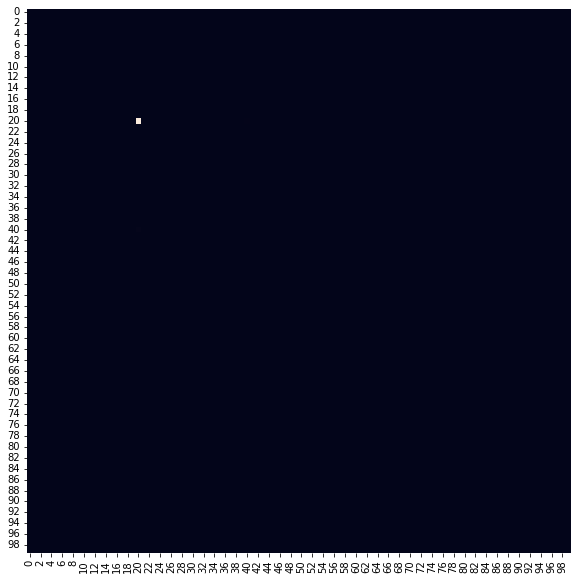

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from celluloid import Camera
from collections import namedtuple, deque
from itertools import count
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
from math import log10, sqrt
device = "mps" if torch.backends.mps.is_available() else "cpu"

input = np.load("input_wofire_16.npy")
output = np.load("output_wofire_16.npy")
sensor_values = np.load("sensor_values_wofire_16.npy")

fig = plt.figure(figsize=(10,10))

def init():
      sns.heatmap(input[0], vmax=.8, square=True, cbar=False)

def animate(i):
    sns.heatmap(input[i], vmax=.8, square=True, cbar=False)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=130, repeat = False)

savefile = r"digital_twin_wofire_16.gif"
pillowwriter = animation.PillowWriter(fps=10)
anim.save(savefile, writer=pillowwriter)

plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from celluloid import Camera
from collections import namedtuple, deque
from itertools import count
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
from math import log10, sqrt
device = "mps" if torch.backends.mps.is_available() else "cpu"

input = np.load("input_wofire_16.npy")
output = np.load("output_wofire_16.npy")
sensor_values = np.load("sensor_values_wofire_16.npy")

fig = plt.figure(figsize=(10,10))

def init():
      sns.heatmap(input[0], vmax=.8, square=True, cbar=False)

def animate(i):
    sns.heatmap(input[i], vmax=.8, square=True, cbar=False)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=124, repeat = False)

savefile = r"digital_twin_wofire.gif"
pillowwriter = animation.PillowWriter(fps=10)
anim.save(savefile, writer=pillowwriter)

plt.show()

/Users/shahmirkhan/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/matplotlib/animation.py:880: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


<Figure size 720x720 with 0 Axes>

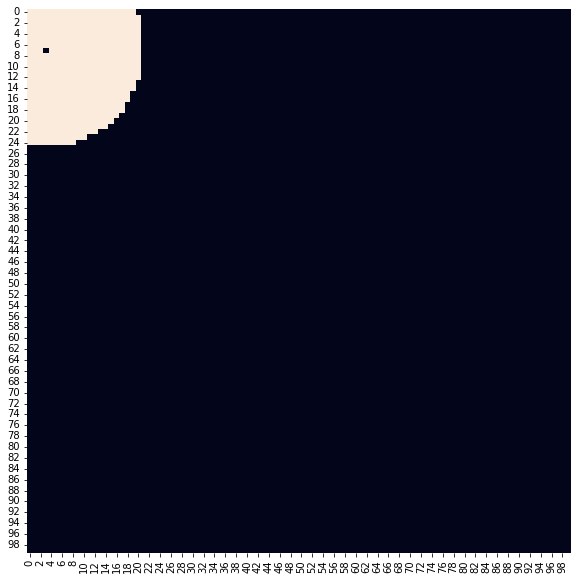

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from celluloid import Camera
from collections import namedtuple, deque
from itertools import count
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
from math import log10, sqrt
device = "mps" if torch.backends.mps.is_available() else "cpu"

input = np.load("input_wofire_16.npy")
output = np.load("output_wofire_16.npy")
sensor_values = np.load("sensor_values_wofire_16.npy")

fig = plt.figure(figsize=(10,10))

def init():
      sns.heatmap(output[0], vmax=.8, square=True, cbar=False)

def animate(i):
    sns.heatmap(output[i], vmax=.8, square=True, cbar=False)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=124, repeat = False)

savefile = r"ground_truth_wofire_16.gif"
pillowwriter = animation.PillowWriter(fps=10)
anim.save(savefile, writer=pillowwriter)

plt.show()

In [8]:
input, time_steps, _ = next(iter(train_dataloader))

In [9]:
y_pred = np.load("masked_fire.npy")
y_pred.shape

(979, 100, 100, 3)

In [7]:

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from celluloid import Camera
from collections import namedtuple, deque
from itertools import count
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
from math import log10, sqrt
from PIL import Image
imgs = np.load("masked_fire.npy").astype('uint8')
imgs = [Image.fromarray(img) for img in imgs]
imgs[0].save("masked_fire.gif", save_all=True, append_images=imgs[1:], duration=10, loop=0)


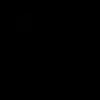

In [11]:
imgs[4]

<ipython-input-22-0f7075e48bbb>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("dm_unet_10K_wofire_16"))


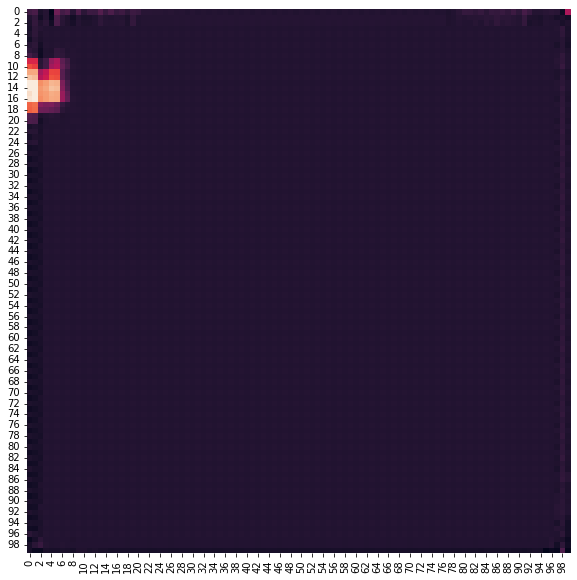

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from celluloid import Camera
from collections import namedtuple, deque
from itertools import count
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
from math import log10, sqrt
device = "mps" if torch.backends.mps.is_available() else "cpu"
model.load_state_dict(torch.load("dm_unet_10K_wofire_16"))
input = np.load("input_wofire_16.npy")
output = np.load("output_wofire_16.npy")
sensor_values = np.load("sensor_values_wofire_16.npy")

input = torch.from_numpy(input)
output = torch.from_numpy(output)
sensor_values = torch.from_numpy(sensor_values)
# last column
time = sensor_values[:,-1]
input, output, time = input.type(torch.float32), output.type(torch.float32), time.type(torch.float32)


input = input.resize_(input.shape[0], 1, input.shape[1], input.shape[2])
output = output.resize_(output.shape[0], 1, output.shape[1], output.shape[2])
# time = time.resize_(time.shape[0], 1)

model = model.to(device)
input = input.to(device)
output = output.to(device)
time = time.to(device)
train_tensor = TensorDataset(input, time, output)
train_dataloader = DataLoader(train_tensor, batch_size=124)
input, time_steps, _ = next(iter(train_dataloader))
y_pred = model(input, time_steps)
y_pred = y_pred.cpu().detach().numpy().reshape(y_pred.shape[0], 100,100)
fig = plt.figure(figsize=(10,10))

def init():
    sns.heatmap(y_pred[0], vmax=.8, square=True, cbar=False)

def animate(i):
    sns.heatmap(y_pred[i], vmax=.8, square=True, cbar=False)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=124, repeat = False)

savefile = r"predicted_fire_wofire_16.gif"
pillowwriter = animation.PillowWriter(fps=10)
anim.save(savefile, writer=pillowwriter)

plt.show()

In [14]:
preds = []
model.load_state_dict(torch.load("dm_unet_10K_wofire_16"))
with torch.no_grad():
    for step, batch in enumerate(train_dataloader):
        y_pred = model(batch[0], batch[1])
        for i in y_pred.cpu().detach().numpy().reshape(y_pred.shape[0], 100,100):
            preds.append(i)
np.save("predicted_firemap_wofire_16.npy", np.array(preds))

<ipython-input-14-2e930d73842a>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("dm_unet_10K_wofire_16"))


In [15]:
preds = np.load("predicted_firemap_wofire_16.npy")

In [16]:
preds[80] > 0.5

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [False,  True,  True, ..., False, False, False]])

In [17]:
psnr_sum = 0
with torch.no_grad():
    for step, batch in enumerate(train_dataloader):
        y_pred = model(batch[0], batch[1])
        for i in range(y_pred.shape[0]):
            squared_sum = ((batch[2][i].resize_(batch[2][i].shape[1], batch[2][i].shape[2])
                            - y_pred[i].resize_(y_pred[i].shape[1], y_pred[i].shape[2])) ** 2).cpu().numpy()
            mse = np.mean(squared_sum)
            if(mse == 0):  # MSE is zero means no noise is present in the signal .
                    # Therefore PSNR have no importance.
                print("The prediction is perfect")
            max_pixel = 1.0
            psnr = 20 * log10(max_pixel / sqrt(mse))
            psnr_sum += psnr
            print("PSNR is: ", psnr)
print("The average psnr is ", psnr_sum/output.shape[0])

PSNR is:  29.79346967808297
PSNR is:  20.578712223574374
PSNR is:  18.35262948309304
PSNR is:  20.454811206880606
PSNR is:  24.175320944738807
PSNR is:  23.805058851287228
PSNR is:  23.996233060237845
PSNR is:  19.613905747732307
PSNR is:  21.84655008765137
PSNR is:  21.943792266208135
PSNR is:  21.338582887501044
PSNR is:  18.81781149413831
PSNR is:  15.773536462358123
PSNR is:  16.076015232685176
PSNR is:  16.21810604141161
PSNR is:  16.20463493263295
PSNR is:  16.992278177240372
PSNR is:  17.132448383661817
PSNR is:  17.0309358722578
PSNR is:  16.88495903644484
PSNR is:  16.756577505143888
PSNR is:  17.219050032824846
PSNR is:  17.6428589888351
PSNR is:  17.842130863933875
PSNR is:  18.30917569989836
PSNR is:  18.765266942737174
PSNR is:  17.60347358486744
PSNR is:  18.147810429543934
PSNR is:  18.05729791541549
PSNR is:  18.39890500874587
PSNR is:  16.447366983062597
PSNR is:  17.092359170846613
PSNR is:  17.798051372970164
PSNR is:  18.375284063527314
PSNR is:  19.366616037060634


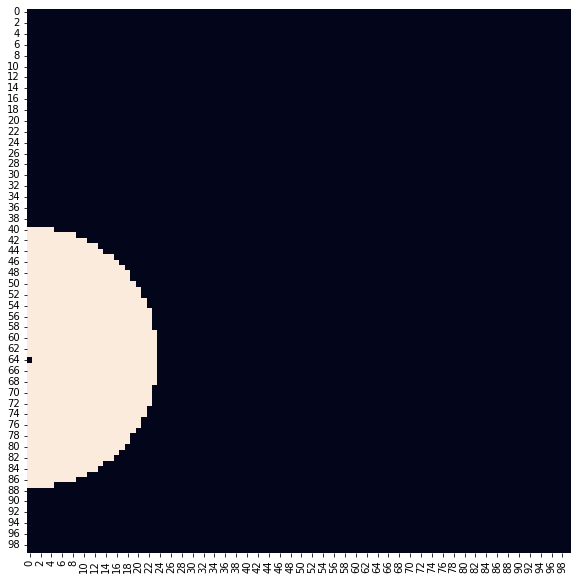

In [36]:
fig = plt.figure(figsize=(10,10))
sns.heatmap(output[10].cpu().numpy().reshape(100,100), vmax=.8, square=True, cbar=False)
plt.show()

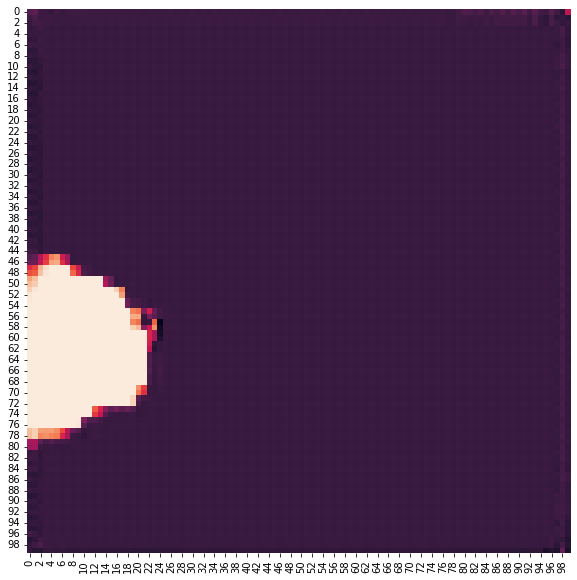

In [40]:
fig = plt.figure(figsize=(10,10))
sns.heatmap(y_pred[7], vmax=.8, square=True, cbar=False)
plt.show()

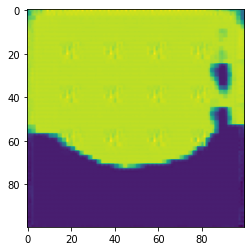

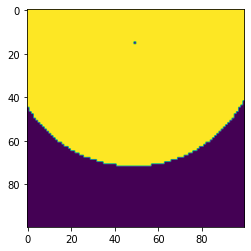

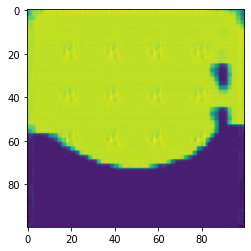

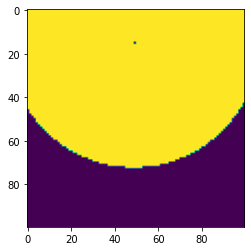

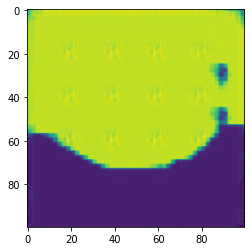

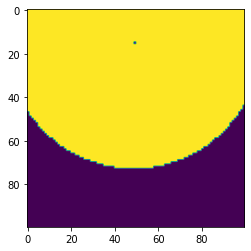

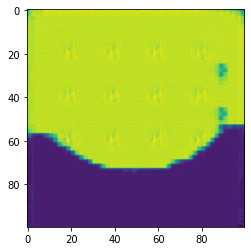

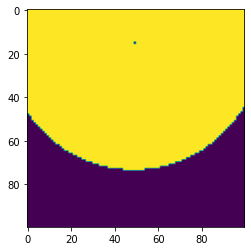

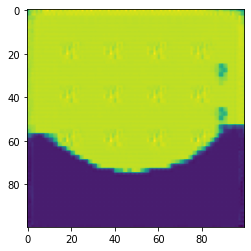

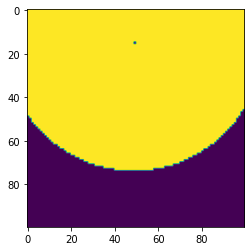

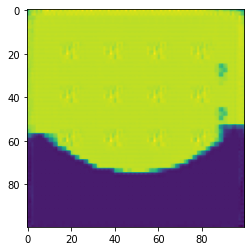

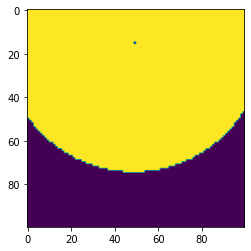

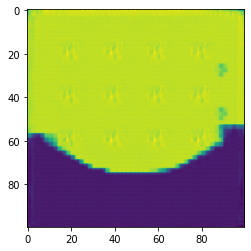

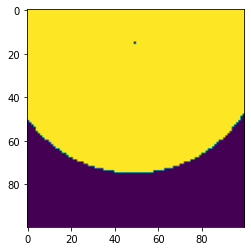

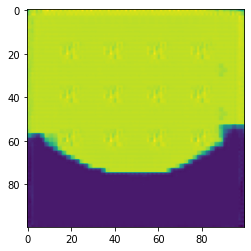

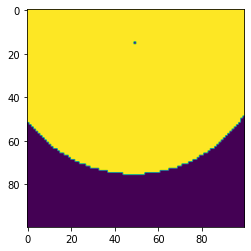

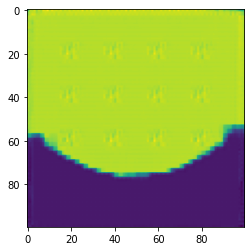

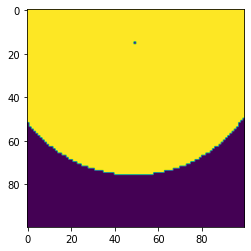

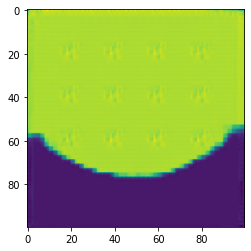

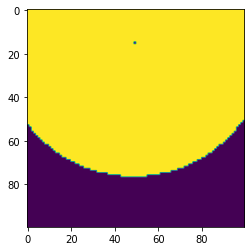

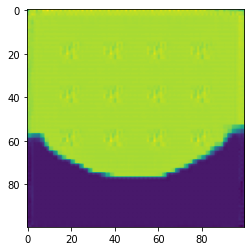

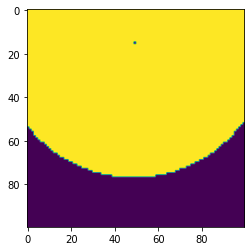

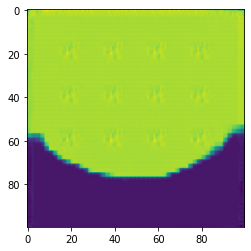

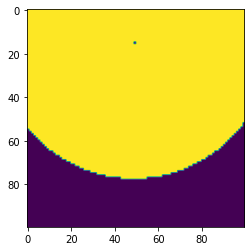

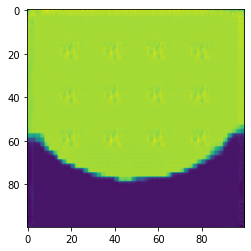

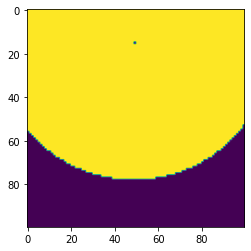

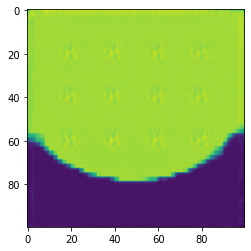

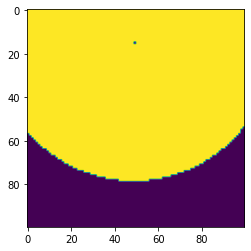

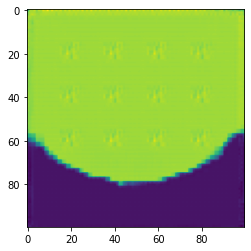

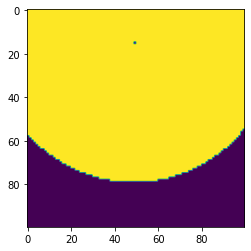

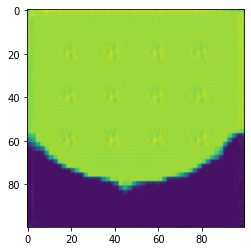

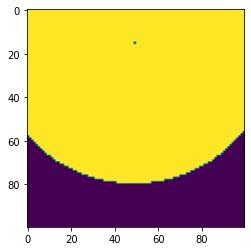

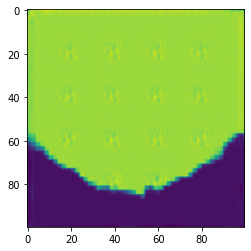

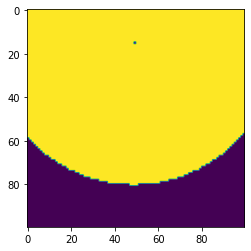

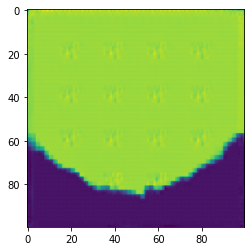

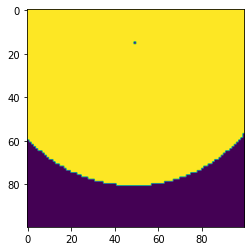

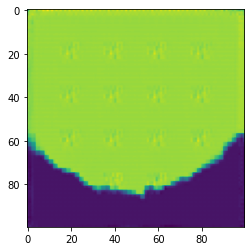

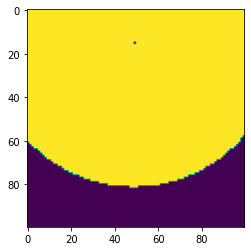

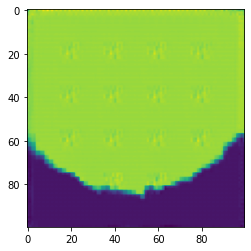

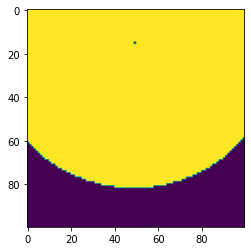

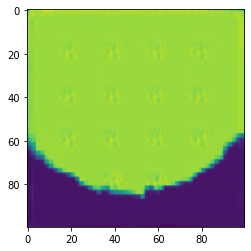

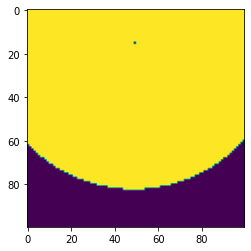

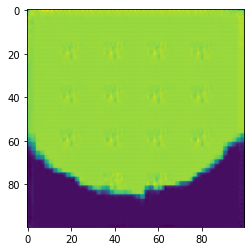

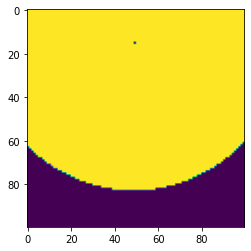

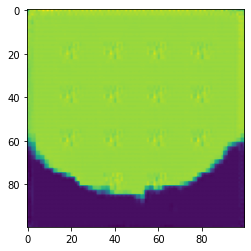

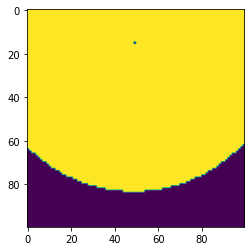

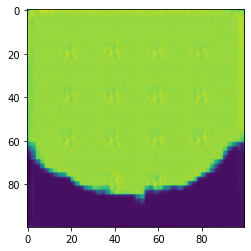

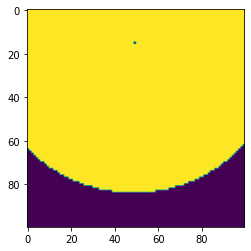

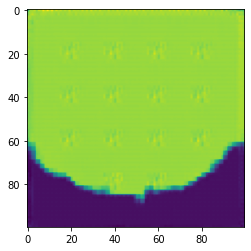

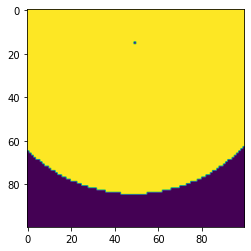

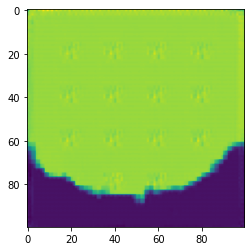

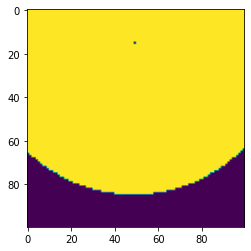

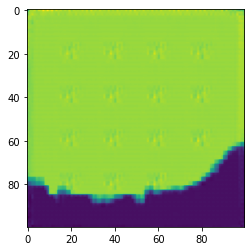

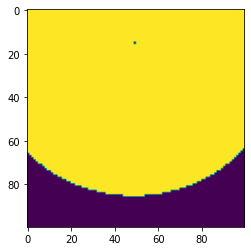

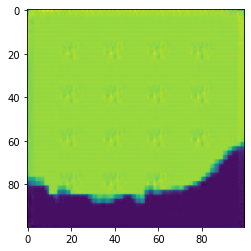

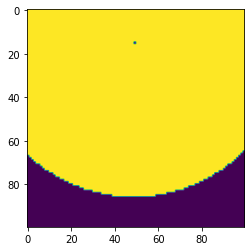

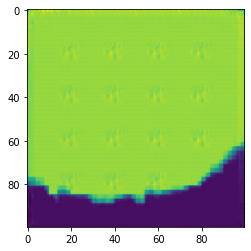

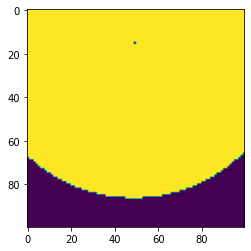

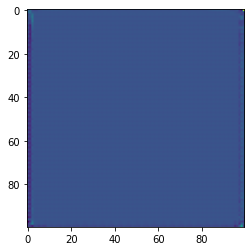

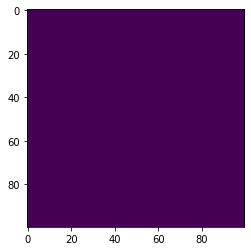

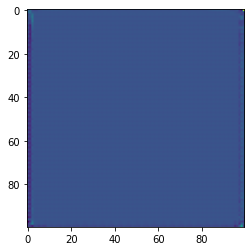

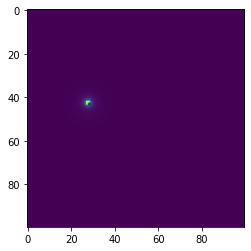

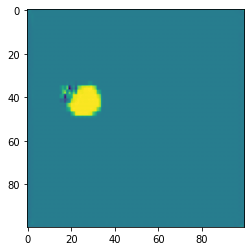

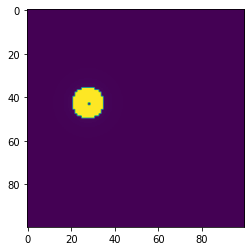

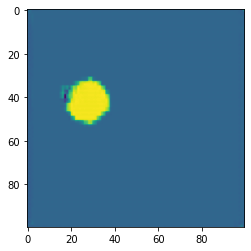

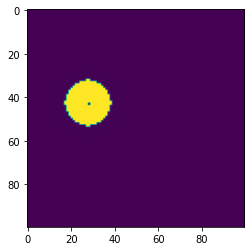

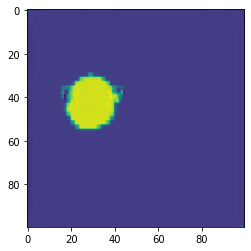

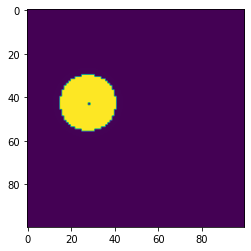

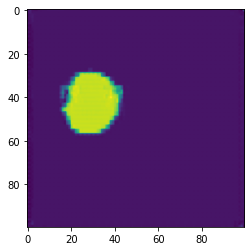

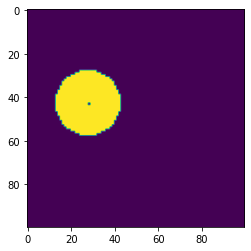

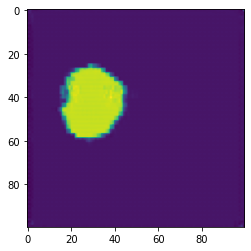

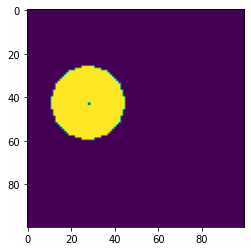

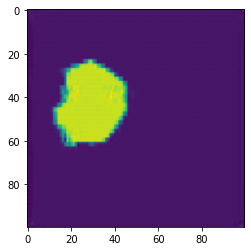

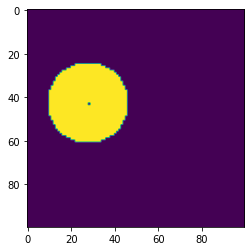

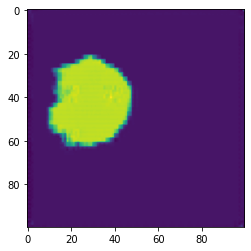

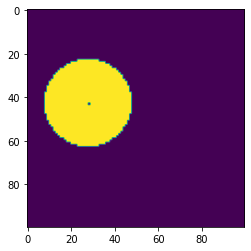

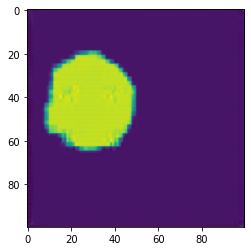

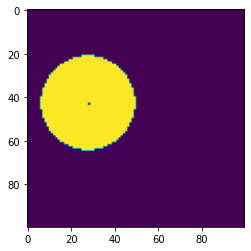

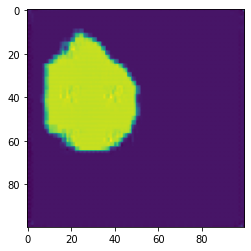

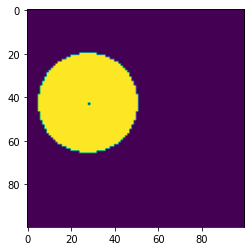

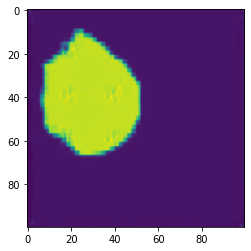

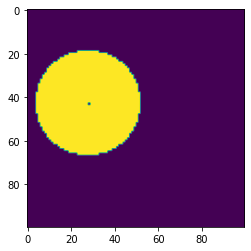

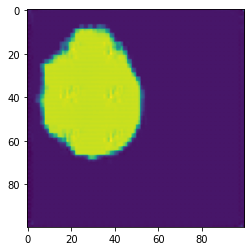

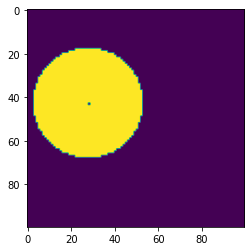

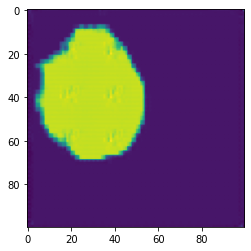

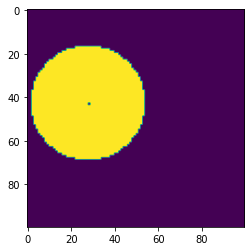

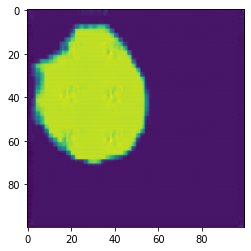

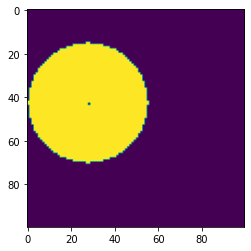

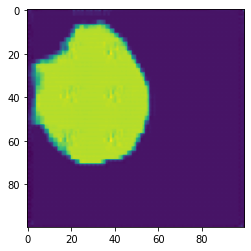

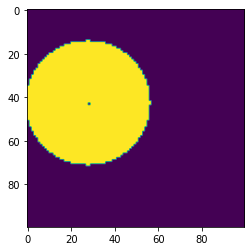

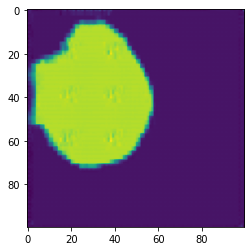

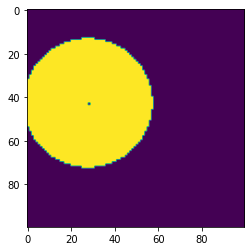

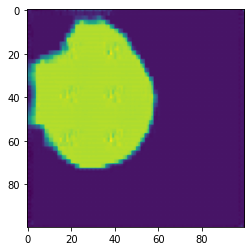

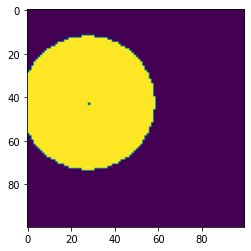

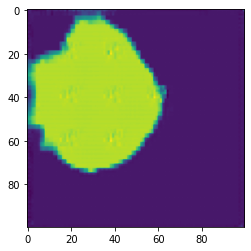

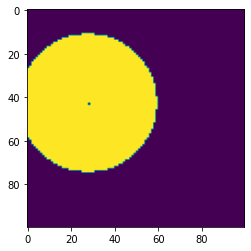

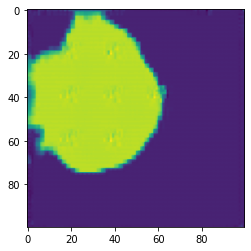

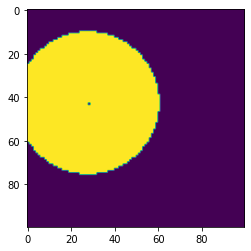

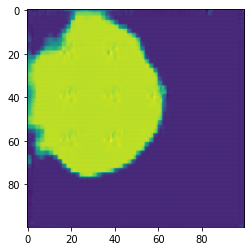

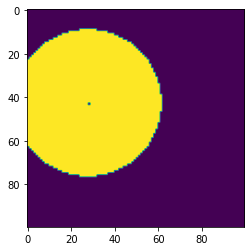

In [ ]:
for i in range(y_pred.shape[0]): 
    plt.imshow(y_pred[i].cpu().numpy().reshape(100,100,1) )
    plt.show()
    plt.imshow(batch[2][i].cpu().numpy().reshape(100,100,1))
    plt.show()


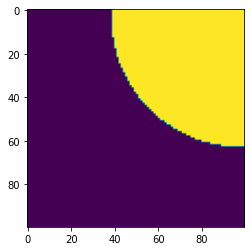

In [8]:
plt.imshow(batch[2][0].cpu().numpy().reshape(100,100,1) )

In [17]:
torch.save(model.state_dict(), "dm_unet_10K")

In [84]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
from math import log10, sqrt
device = "mps" if torch.backends.mps.is_available() else "cpu"

class Attention_Gate(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.in_c = in_c
        self.out_c = out_c
        self.Wg = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=1, padding=0),
            nn.BatchNorm2d(out_c)
        )
        self.Ws = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=1, padding=0),
            nn.BatchNorm2d(out_c)
        )
        self.relu = nn.ReLU(inplace=True)
        self.output = nn.Sequential(
            nn.Conv2d(out_c, out_c, kernel_size=1, padding=0),
            nn.Sigmoid()
        )
 
    def forward(self, g, s):
        # print(self.in_c, self.out_c)
        # print(g.shape)
        Wg = self.Wg(g)
        Ws = self.Ws(s)
        out = self.relu(Wg + Ws)
        out = self.output(out)
        return out 

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        self.up = up
        if up:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.ag = Attention_Gate(in_ch, in_ch)
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
            self.pool = nn.MaxPool2d((2, 2))
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, p=None):
        # First Conv
        if self.up:
            p = self.ag(x, p)
            # x = nn.Conv2d(x.shape[1], int(x.shape[1]/2), 1, padding=0).to(device)(x)
            x = torch.cat([x, p], axis=1)
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        h = self.transform(h)
        if not self.up:
            p = self.pool(h)
        return h, p


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 1
        down_channels = (16, 32, 64)
        self.up_channels = (64, 32, 16)
        out_dim = 1
        time_emb_dim = 16

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.pool = nn.MaxPool2d((2, 2))
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], time_emb_dim) for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(self.up_channels[i], self.up_channels[i+1], time_emb_dim, up=True) for i in range(len(self.up_channels)-1)])
        
        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(self.up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        downsample_layers = []
        for down in self.downs:
            x, p = down(x, t, )
            residual_inputs.append(x)
            downsample_layers.append([x, p])
        i = 0
        for up in self.ups:
            residual_x = residual_inputs.pop()
            downsample_layer_conv, downsample_layer_pool = downsample_layers.pop()
            # Add residual x as additional channels
            # print(x.shape, residual_x.shape)
            x = torch.cat((x, residual_x), dim=1)
            x = nn.Conv2d(x.shape[1], self.up_channels[i], 1, padding=0).to(device)(x)
            # downsample_layer_conv = self.up(downsample_layer_conv)
            x, _ = up(x, t, downsample_layer_conv)
            i += 1
        return self.output(x)

model = SimpleUnet()
# summary(model, [(1,100, 100), (1,1)])


def get_loss(model, x, y, t):
    y_pred = model(x, t)
    return F.l1_loss(y, y_pred)     




input = np.load("input.npy")
output = np.load("output.npy")
sensor_values = np.load("sensor_values.npy")

input = torch.from_numpy(input)
output = torch.from_numpy(output)
sensor_values = torch.from_numpy(sensor_values)
# last column
time = sensor_values[:,-1]
input, output, time = input.type(torch.float32), output.type(torch.float32), time.type(torch.float32)


input = input.resize_(input.shape[0], 1, input.shape[1], input.shape[2])
output = output.resize_(output.shape[0], 1, output.shape[1], output.shape[2])
# time = time.resize_(time.shape[0], 1)

model = model.to(device)
input = input.to(device)
output = output.to(device)
time = time.to(device)
train_tensor = TensorDataset(input, time, output)
train_dataloader = DataLoader(train_tensor, batch_size=50)
optimizer = Adam(model.parameters(), lr=0.0001)
epochs = 2000 # Try more!

for epoch in range(epochs):
    for step, batch in enumerate(train_dataloader):
      optimizer.zero_grad()
      t = batch[1]
      loss = get_loss(model, batch[0], batch[2], t)
      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | Loss: {loss.item()} ")

Epoch 0 | Loss: 0.3914896547794342 
Epoch 5 | Loss: 0.13778848946094513 
Epoch 10 | Loss: 0.12630295753479004 
Epoch 15 | Loss: 0.12895488739013672 
Epoch 20 | Loss: 0.12886695563793182 
Epoch 25 | Loss: 0.13118194043636322 
Epoch 30 | Loss: 0.13348393142223358 
Epoch 35 | Loss: 0.13555890321731567 
Epoch 40 | Loss: 0.13217754662036896 
Epoch 45 | Loss: 0.13345454633235931 
Epoch 50 | Loss: 0.13321100175380707 
Epoch 55 | Loss: 0.13282962143421173 
Epoch 60 | Loss: 0.12842117249965668 
Epoch 65 | Loss: 0.1265658736228943 
Epoch 70 | Loss: 0.12722553312778473 
Epoch 75 | Loss: 0.11758839339017868 
Epoch 80 | Loss: 0.11266519874334335 
Epoch 85 | Loss: 0.10889408737421036 
Epoch 90 | Loss: 0.10060448199510574 
Epoch 95 | Loss: 0.08983343839645386 
Epoch 100 | Loss: 0.09242931008338928 
Epoch 105 | Loss: 0.08811355382204056 
Epoch 110 | Loss: 0.08338814228773117 
Epoch 115 | Loss: 0.07312105596065521 
Epoch 120 | Loss: 0.0727778747677803 
Epoch 125 | Loss: 0.06453143805265427 
Epoch 130 |

In [18]:
psnr_sum = 0
with torch.no_grad():
    for step, batch in enumerate(train_dataloader):
        y_pred = model(batch[0], batch[1])
        for i in range(y_pred.shape[0]):
            squared_sum = ((batch[2][i].resize_(batch[2][i].shape[1], batch[2][i].shape[2])
                            - y_pred[i].resize_(y_pred[i].shape[1], y_pred[i].shape[2])) ** 2).cpu().numpy()
            mse = np.mean(squared_sum)
            if(mse == 0):  # MSE is zero means no noise is present in the signal .
                    # Therefore PSNR have no importance.
                print("The prediction is perfect")
            max_pixel = 1.0
            psnr = 20 * log10(max_pixel / sqrt(mse))
            psnr_sum += psnr
            print("PSNR is: ", psnr)
print("The average psnr is ", psnr_sum/output.shape[0])

PSNR is:  29.79346967808297
PSNR is:  20.578712223574374
PSNR is:  18.35262948309304
PSNR is:  20.454811206880606
PSNR is:  24.175320944738807
PSNR is:  23.805058851287228
PSNR is:  23.996233060237845
PSNR is:  19.613905747732307
PSNR is:  21.84655008765137
PSNR is:  21.943792266208135
PSNR is:  21.338582887501044
PSNR is:  18.81781149413831
PSNR is:  15.773536462358123
PSNR is:  16.076015232685176
PSNR is:  16.21810604141161
PSNR is:  16.20463493263295
PSNR is:  16.992278177240372
PSNR is:  17.132448383661817
PSNR is:  17.0309358722578
PSNR is:  16.88495903644484
PSNR is:  16.756577505143888
PSNR is:  17.219050032824846
PSNR is:  17.6428589888351
PSNR is:  17.842130863933875
PSNR is:  18.30917569989836
PSNR is:  18.765266942737174
PSNR is:  17.60347358486744
PSNR is:  18.147810429543934
PSNR is:  18.05729791541549
PSNR is:  18.39890500874587
PSNR is:  16.447366983062597
PSNR is:  17.092359170846613
PSNR is:  17.798051372970164
PSNR is:  18.375284063527314
PSNR is:  19.366616037060634
